In [78]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
pd.options.display.float_format = '{:.3f}'.format
df_seoul = pd.read_csv('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/CARD_SPENDING_RESIDENT/CARD_SPENDING_RESIDENT.txt', delimiter='\t')
df_seoul.columns = ['기준일자', '구코드', '행정동코드', '업종코드', '성별코드', '나이코드', '이용건수', '이용금액']
df_seoul = df_seoul.query("구코드 in ['140','350']").set_index('구코드')
df_dong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 행정동코드', skiprows=1)
df_upjong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 업종코드', skiprows=1)
df_upjong_code = df_upjong_code[['업종코드 (32개 분류)']]
df_upjong_code.dropna(inplace=True)

In [80]:
#동 코드 서울만 가져오기
df_dong_code = df_dong_code[:34]

In [81]:
df_seoul

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액
구코드,,,,,,,
140,20190201,520,10,F,20,14,1038
140,20190201,520,10,F,25,59,4635
140,20190201,520,10,F,30,41,3046
140,20190201,520,10,F,35,59,5995
140,20190201,520,10,F,40,45,5172
...,...,...,...,...,...,...,...
350,20200531,720,81,M,45,19,127
350,20200531,720,81,M,50,33,211
350,20200531,720,81,M,55,9,61


In [82]:
# 각종 코드와 실제 명칭을 딕셔너리 형태로 만든다
upjong_dic={}
gu_dic={}
gu_dong_dic={}
weekday_dic={0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'}
for i, j in zip(df_dong_code['구코드'], df_dong_code['구명']):
    gu_dic[i]=j
for i, j, x, y in zip(df_dong_code['구코드'], df_dong_code['구명'], df_dong_code['행정동코드'], df_dong_code['행정동명']):
    gu_dong_dic[(i,x)]=y
for i in df_upjong_code.values:
    key = re.findall('\((.*)\)',i[0])[0]
    val = re.findall('(.*)\(',i[0])[0]
    upjong_dic[key]=val

In [83]:
#type 바꿔주기
df_seoul['기준일자'] = df_seoul['기준일자'].astype(str)
df_seoul['기준일자'] = pd.to_datetime(df_seoul['기준일자'])
df_seoul['업종코드'] = df_seoul['업종코드'].astype(str)

#시구, 동, 업종코드 mapping
df_seoul['시_구'] = df_seoul.index.map(gu_dic)
df_seoul['행정동'] = [gu_dong_dic[(i,x)] for i,x in zip(df_seoul.index, df_seoul['행정동코드'])]
df_seoul['업종'] = df_seoul['업종코드'].map(upjong_dic)
df_seoul['Year'] = df_seoul['기준일자'].dt.year
df_seoul['Month'] = df_seoul['기준일자'].dt.month
df_seoul['요일'] = df_seoul['기준일자'].dt.weekday.map(weekday_dic)
from copy import deepcopy
df_origin = deepcopy(df_seoul)

구별 (업종별, 성별, 나이별, (이용금액,건수))
140:중구, 350:노원구

In [84]:
df_set={}

In [85]:
df_0 = df_seoul[['시_구','업종','Year','이용건수','이용금액']].groupby(['시_구','업종','Year']).mean()

In [101]:
df_1 = df_seoul.query('업종 not in ["의료기관", "보건위생", "자동차정비"]')

df_1 = df_1[['시_구','행정동','업종','Year','Month','이용건수','이용금액']].groupby(['시_구','행정동','Month','업종','Year']).mean()
#이용건수가 100이상인것만 자료로 취급한다
df_1 = df_1.query('Year==2020 or (Year==2019 and 이용건수>50)')

In [102]:
test = df_1.reset_index().set_index(['시_구','행정동','Month','업종'])
#2019가 없는 항목은 제외시키기
for i in test.index:
    if len(test.loc[i])!=2:
        test.drop(i,inplace=True)
df_1 = test.reset_index().set_index(['시_구','행정동','Month','업종','Year'])

In [106]:
#구와 동을 입력하면 월별 업종별 전년대비 이용금액변화율을 plotting 한다
def gu_dong(gu, dong):
    for m in df_seoul.Month.unique():
        if m == 2:
            df_2 = df_1.loc[gu,dong,m].T  
            ##여기에다가 이용건수에대한 threshold 주면좋을듯 
            
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new = pd.DataFrame(a)
            df_new.columns = ['2월']
        
        else : 
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new['{}월'.format(m)] = a
    df_new = df_new.stack().reset_index()
    df_new.columns = ['업종','월','전년대비_변화율']
    sns.barplot(data = df_new, x = '업종', y = '전년대비_변화율', hue='월')
    plt.ylim(-100, 100)
    plt.grid(which='major', axis='y') 
    plt.title(dong, {'fontsize' : 25, 'color':'black'})
    

In [107]:
print(len(df_seoul[df_seoul['시_구']=='서울 중구']['행정동'].unique()))
print(len(df_seoul[df_seoul['시_구']=='서울 노원구']['행정동'].unique()))

15
19


In [108]:
#중구, 노원구 모든 동에대해 plotting하기위한 함수
def makefigure(gu):
    Fig=plt.figure(figsize=(20,50))
    for i,dong in enumerate(df_seoul[df_seoul['시_구']==gu]['행정동'].unique()):
        Fig.add_subplot(ceil(len(df_seoul[df_seoul['시_구']==gu]['행정동'].unique())/2),2,i+1) 
        gu_dong(gu, dong)
    Fig.tight_layout()
    Fig.show()
    figure_dir = './img'
    import os
    if os.path.isdir(figure_dir) == False:
        os.mkdir(figure_dir)
    Fig.savefig(figure_dir+'/{}전년대비이용금액.png'.format(gu))
    Fig.show()

C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


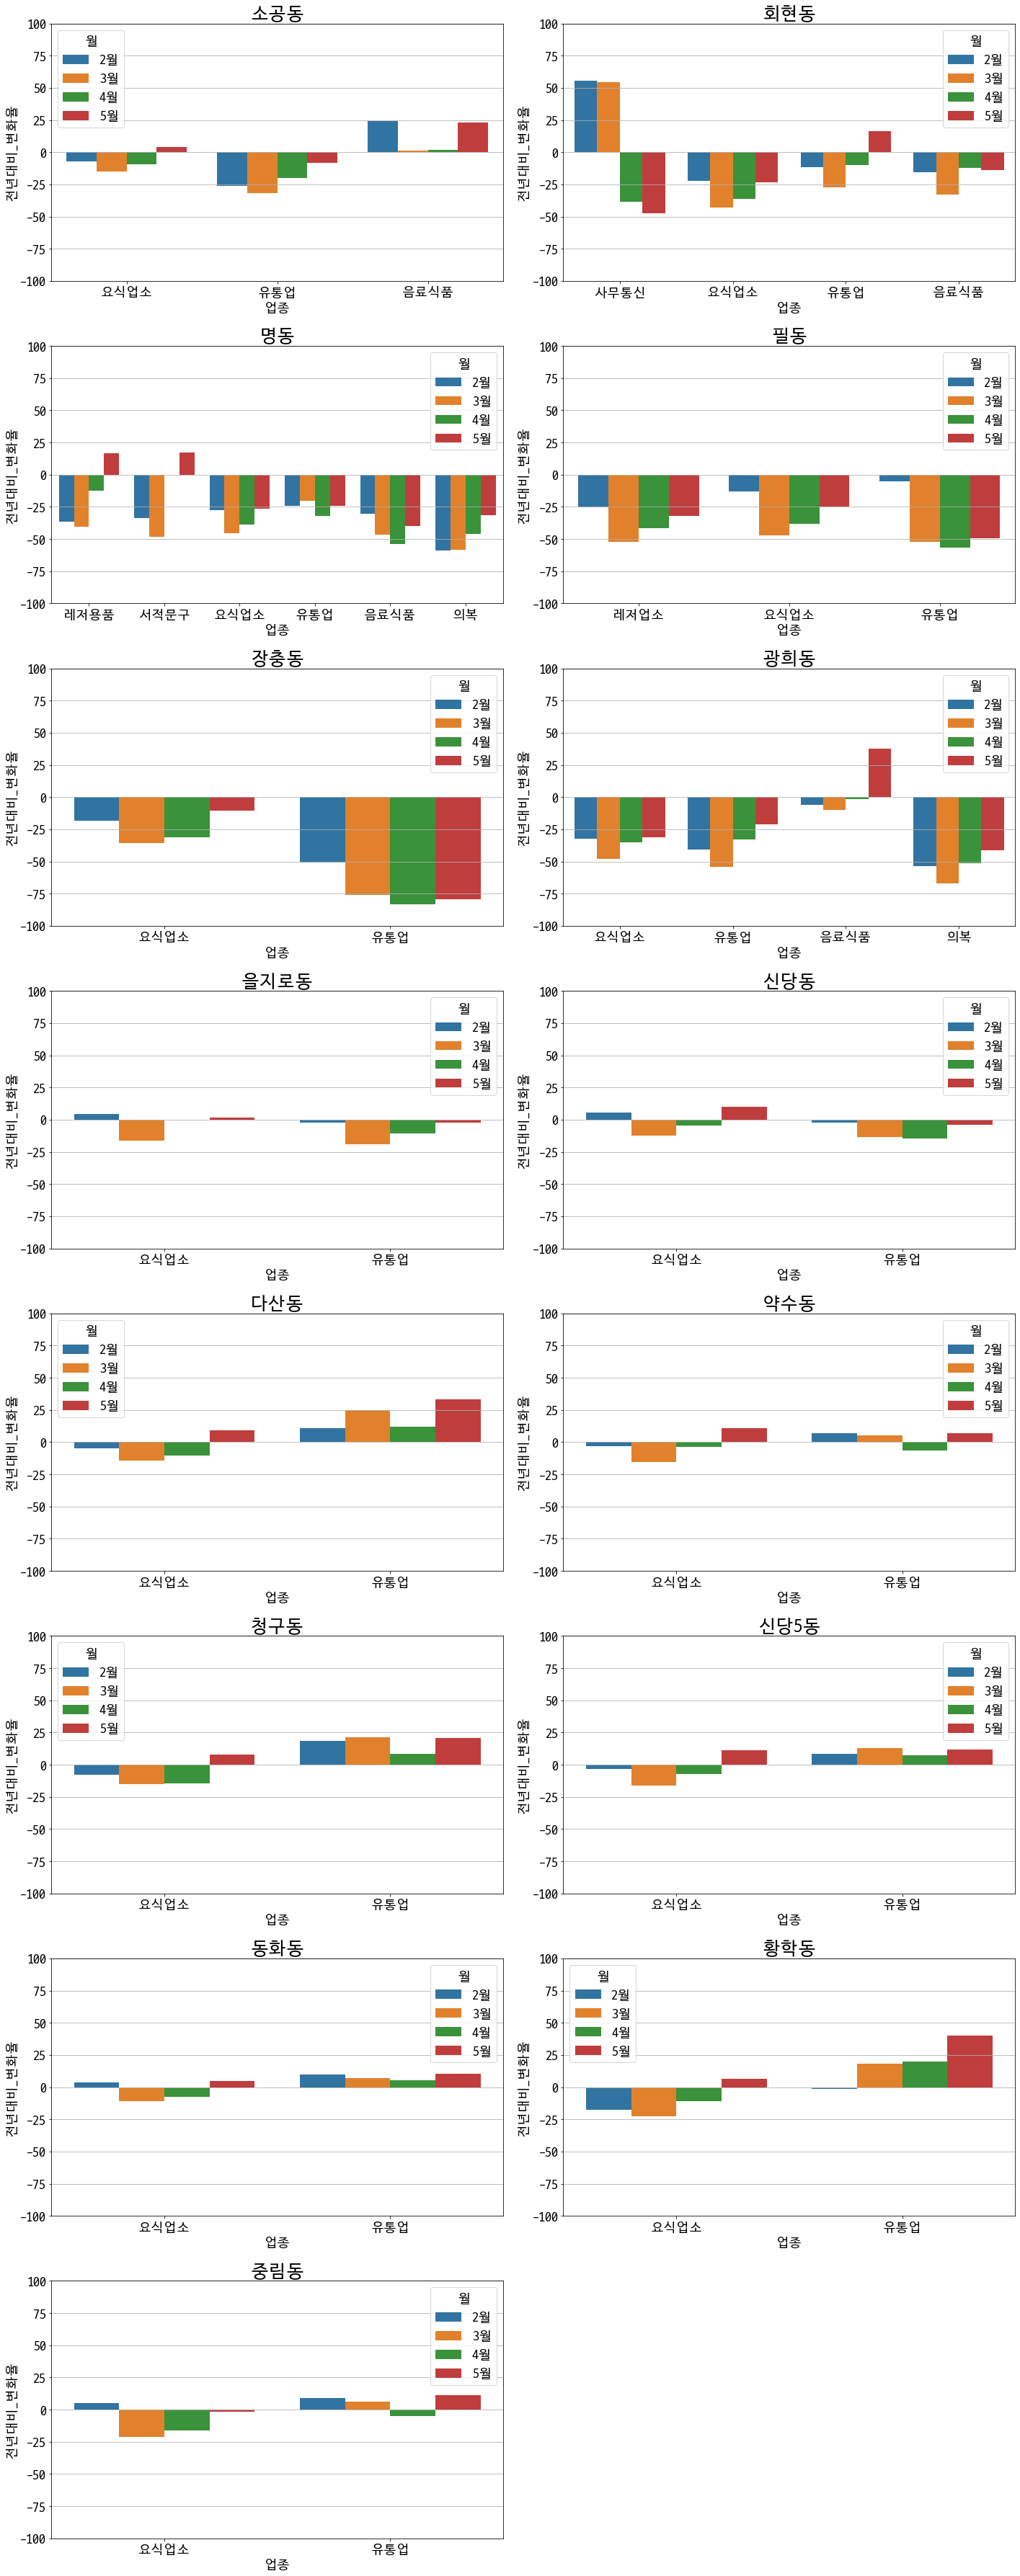

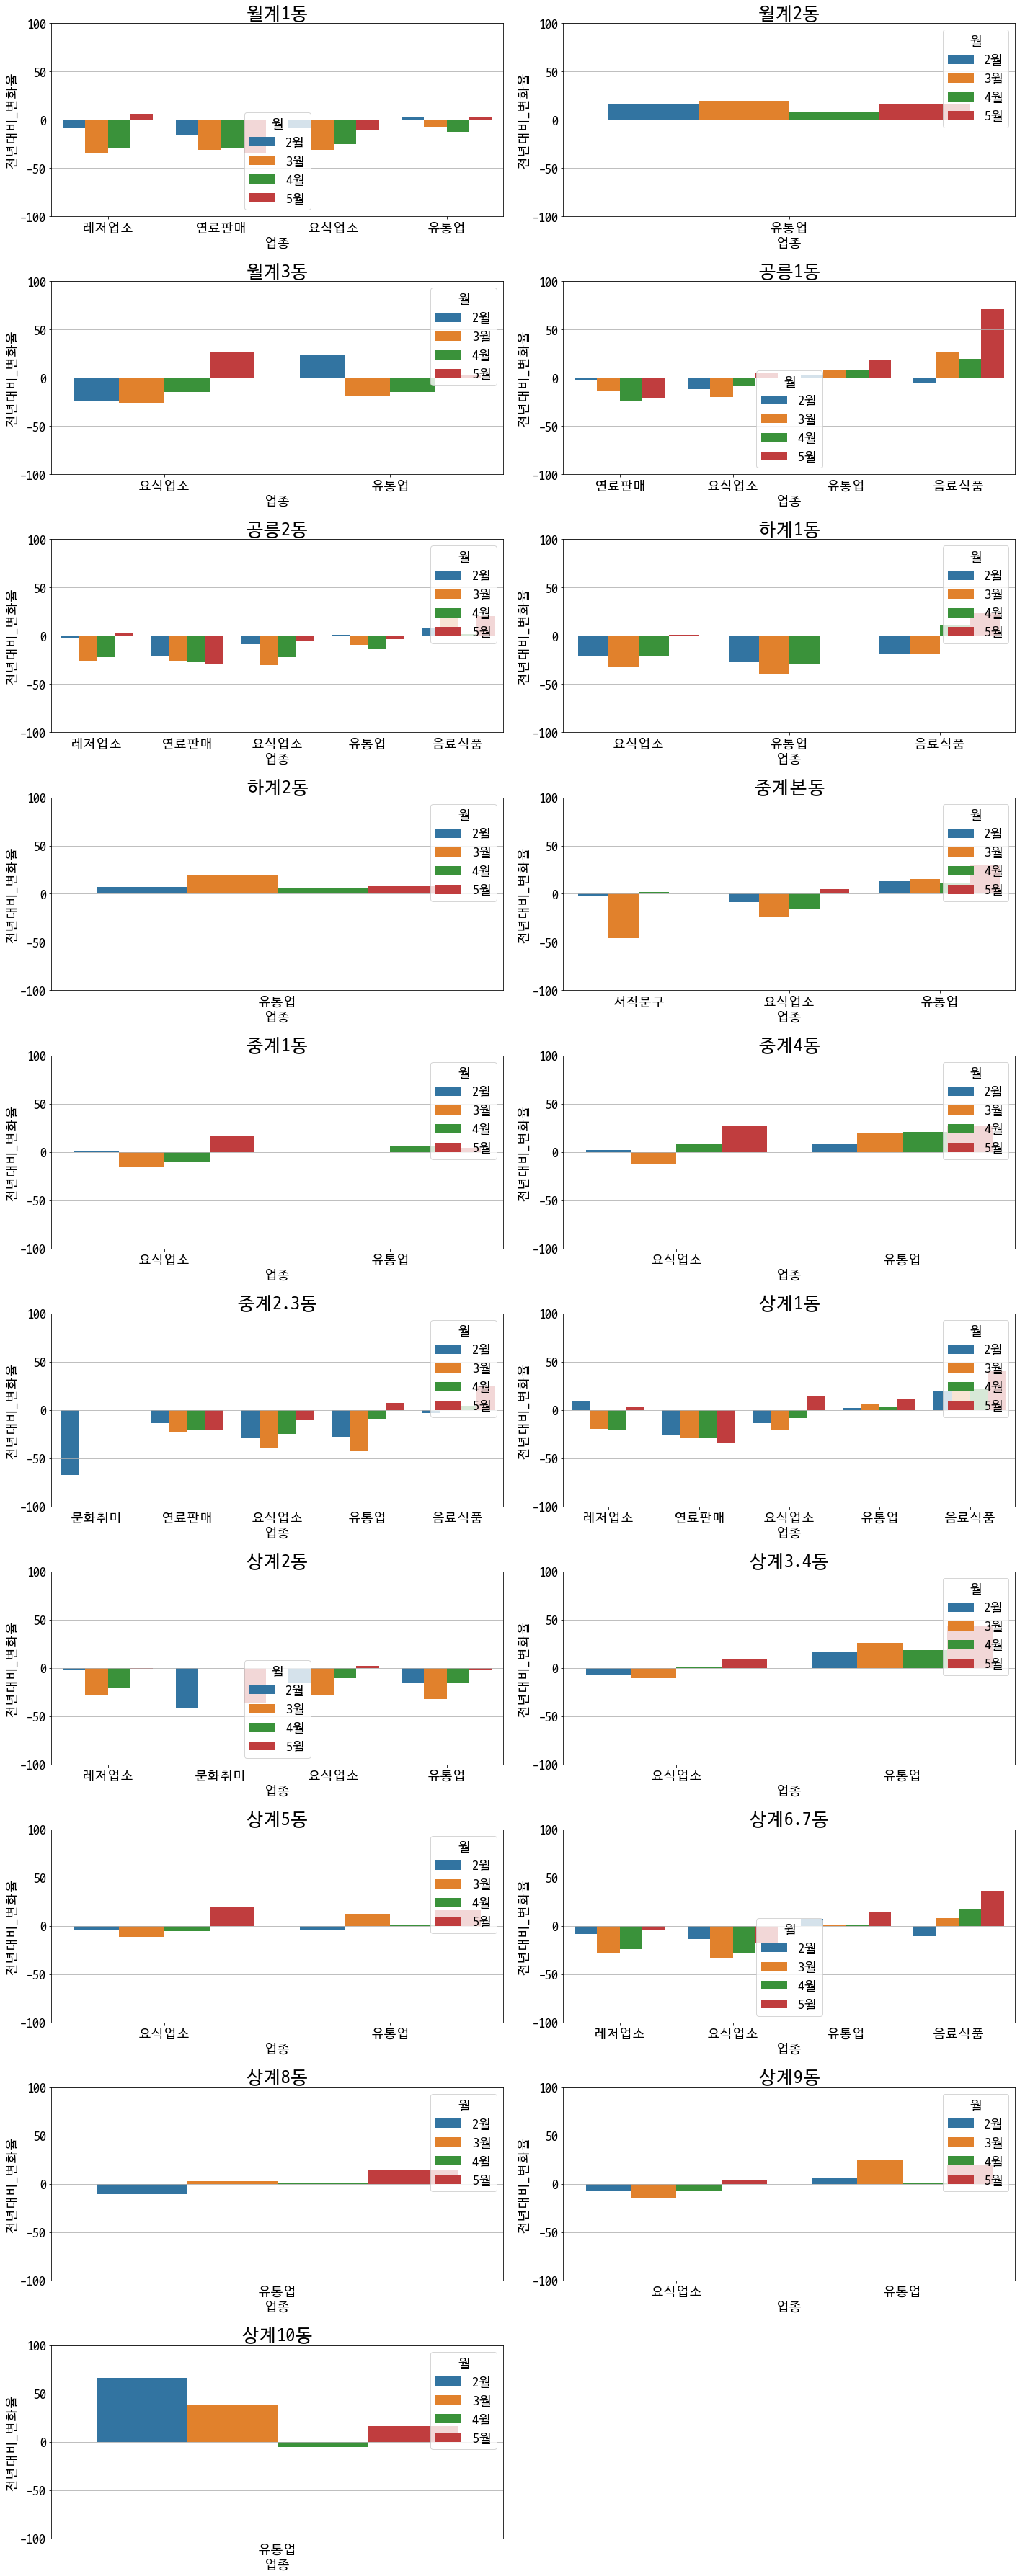

In [109]:
from math import ceil

for gu in ['서울 중구','서울 노원구']:
    makefigure(gu)
    
#신한카드가 가계의 매출전체를 대변할 수는 없지만 경향성을 설명해줄수 있다

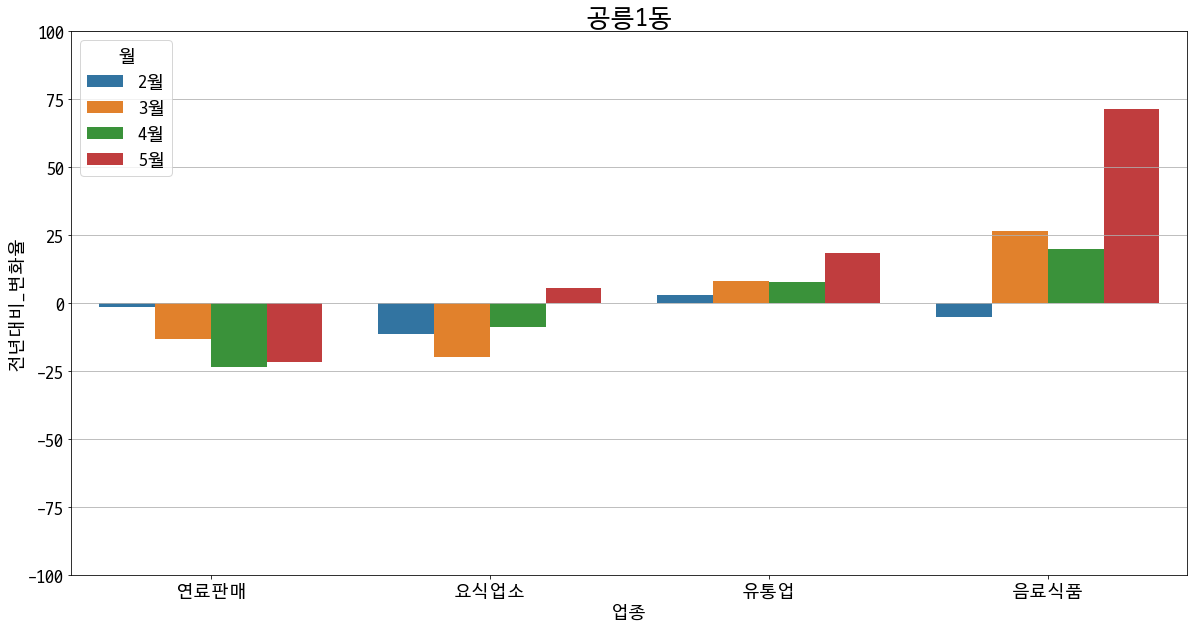

In [110]:
plt.rcParams['figure.figsize'] = [20,10]
gu_dong('서울 노원구','공릉1동')

# 노원구 중구의 코로나 이전(2019)과 이후(2020) 업종별 이용건수 이용금액 추이

In [111]:
df_no_jung = df_0.loc['서울 노원구'] + df_0.loc['서울 중구']

In [112]:
df_pr = df_no_jung.reset_index().groupby(['업종']).sum()
idx_list = df_pr.sort_values(by=['이용건수'])[-10:].index.tolist()

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

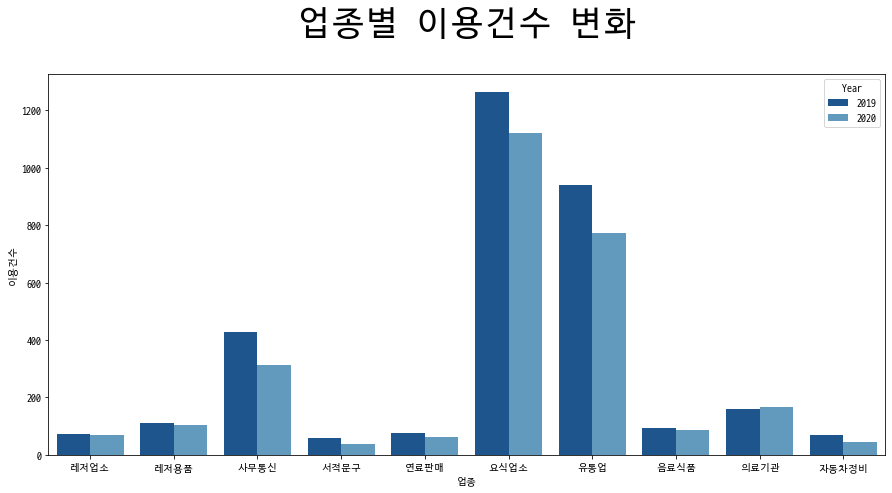

In [131]:

plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams.update({'font.size': 10})
pal = sns.color_palette("Blues_r")
g1 = sns.barplot(data = df_no_jung.query('업종 in {}'.format(idx_list)).reset_index(),x='업종', y='이용건수',hue='Year', ci=None,palette=pal[::2])
plt.title('업종별 이용건수 변화\n', {'fontsize' : 34, 'color':'black'})
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

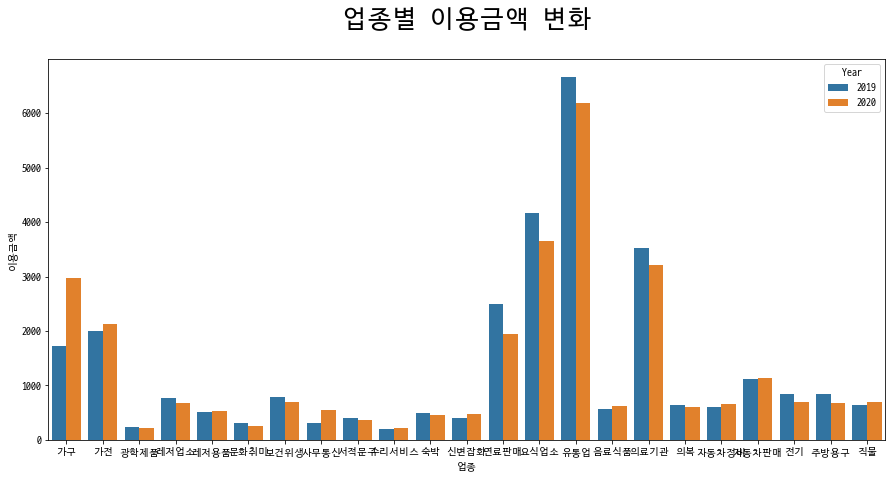

In [132]:
g2 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)
plt.title('업종별 이용금액 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

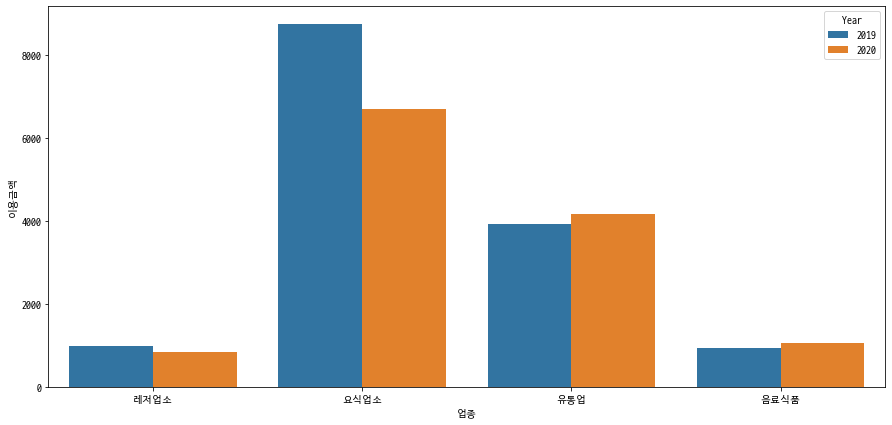

In [133]:
g3 = sns.barplot(data = df_1.loc['서울 노원구','상계6.7동'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [134]:
df_set['동별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['행정동','기준일자'],as_index=True).sum()[['이용건수','이용금액']]
df_set['업종별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['업종','기준일자'],as_index=True).sum()[['이용건수','이용금액']]

---

---
# 전년비 주말or전체 20대 카드이용비중
고객의 비중이 어떻게 되는지 몰라서 정확하지 않을수 있다

In [137]:
from math import floor
df_origin['나이대']=[i//10*10 for i in df_origin['나이코드']]
df_nai = df_origin

In [138]:
df_nai.head()

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,시_구,행정동,업종,Year,Month,요일,나이대
구코드,,,,,,,,,,,,,,
140,2019-02-01,520,10,F,20,14,1038,서울 중구,소공동,숙박,2019,2,금,20
140,2019-02-01,520,10,F,25,59,4635,서울 중구,소공동,숙박,2019,2,금,20
140,2019-02-01,520,10,F,30,41,3046,서울 중구,소공동,숙박,2019,2,금,30
140,2019-02-01,520,10,F,35,59,5995,서울 중구,소공동,숙박,2019,2,금,30
140,2019-02-01,520,10,F,40,45,5172,서울 중구,소공동,숙박,2019,2,금,40


In [139]:
df_nai_all = df_nai[['업종','나이대','이용건수','이용금액']].groupby(['업종','나이대']).mean()

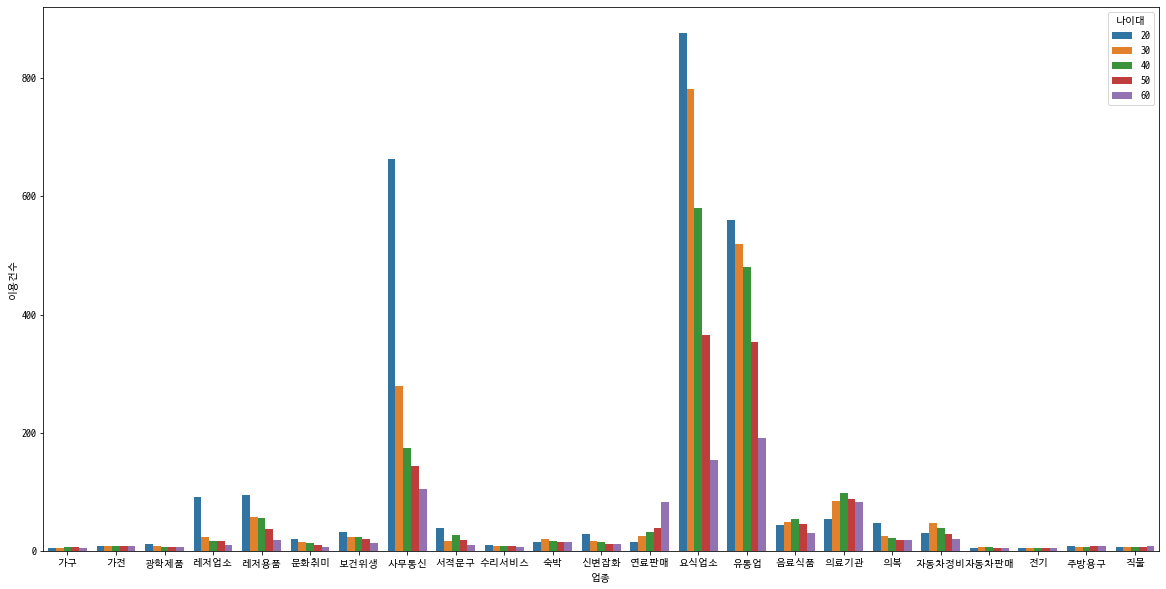

In [140]:
plt.rcParams['figure.figsize'] = [20,10]
sns.barplot(data = df_nai_all.reset_index(), x = '업종', y = '이용건수', hue='나이대')

### 카드이용량 전체를 보았을때 요식업소이용률은 20대가 가장 많았다
### 우리가 카페 음식점 술집 중심으로 서비스를 진행하려고 하기 때문에 요식업소를 중점으로 보겠다

In [141]:
df_nai_yosik = df_nai.query('업종=="요식업소" and Year==2020')

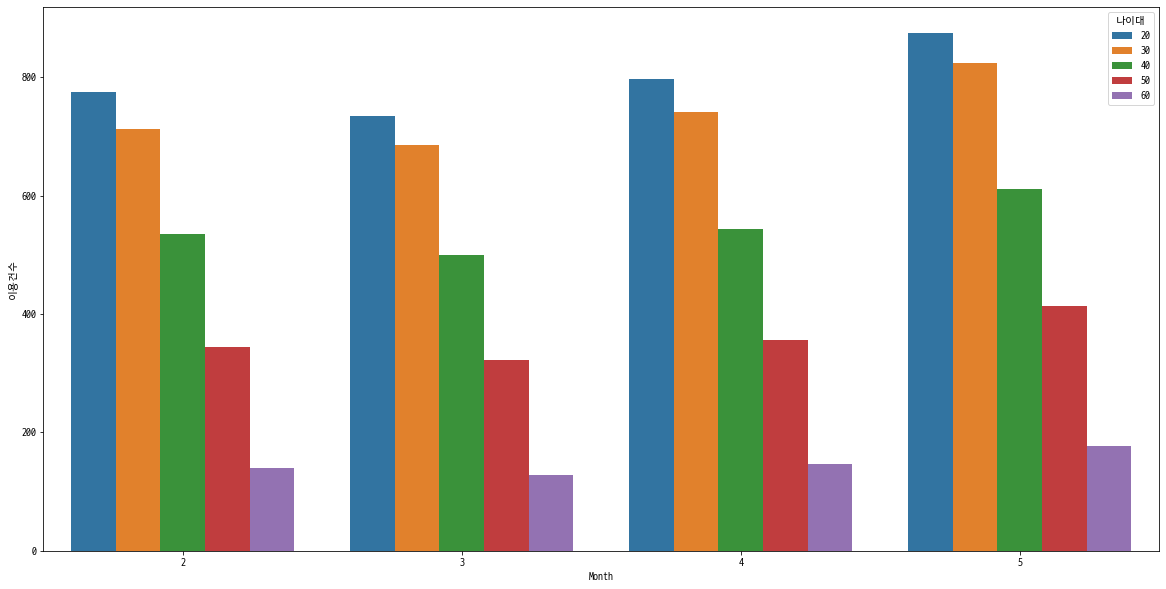

In [142]:
sns.barplot(data = df_nai_yosik[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')

# 주말만 보면

In [143]:
df_nai_yosik = df_nai.query('업종=="요식업소" and Year==2020 and 요일==["토","일"]')
df_nai_yosik_myung = df_nai.query('업종=="요식업소" and Year==2020 and 요일==["토","일"] and 행정동=="명동"')
df_nai_yosik_gong =  df_nai.query('업종=="요식업소" and Year==2020 and 요일==["토","일"] and 행정동=="공릉2동"')

In [144]:
df_nai_yosik_19 = df_nai.query('업종=="요식업소" and Year==2019 and 요일==["토","일"]')
df_nai_yosik_myung_19 = df_nai.query('업종=="요식업소" and Year==2019 and 요일==["토","일"] and 행정동=="명동"')
df_nai_yosik_gong_19 =  df_nai.query('업종=="요식업소" and Year==2019 and 요일==["토","일"] and 행정동=="공릉2동"')

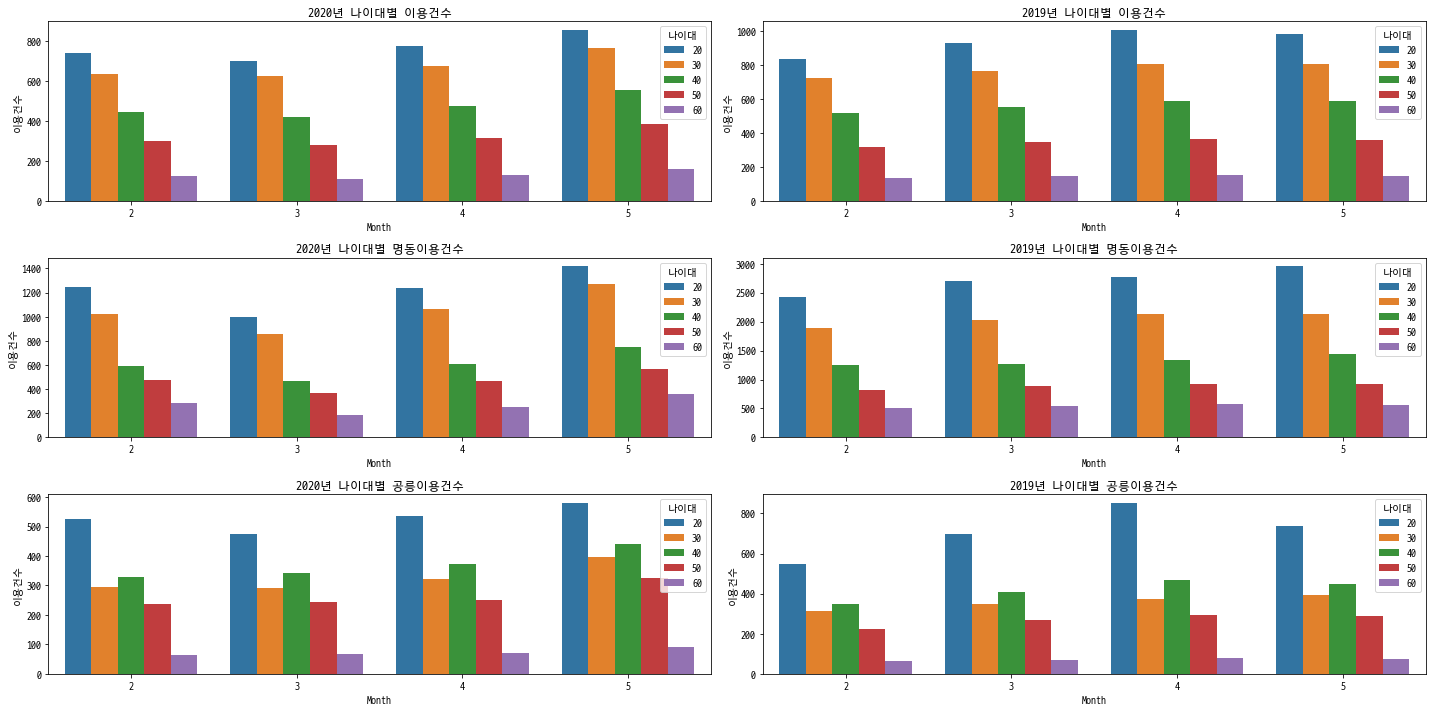

In [145]:
fig = plt.figure(figsize=(20,10))

fig.add_subplot(3,2,1)
plt.title('2020년 나이대별 이용건수')
sns.barplot(data = df_nai_yosik[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')
fig.add_subplot(3,2,2)
plt.title('2019년 나이대별 이용건수')
sns.barplot(data = df_nai_yosik_19[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')

fig.add_subplot(3,2,3)
plt.title('2020년 나이대별 명동이용건수')
sns.barplot(data = df_nai_yosik_myung[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')
fig.add_subplot(3,2,4)
plt.title('2019년 나이대별 명동이용건수')
sns.barplot(data = df_nai_yosik_myung_19[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')


fig.add_subplot(3,2,5)
plt.title('2020년 나이대별 공릉이용건수')
sns.barplot(data = df_nai_yosik_gong[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')
fig.add_subplot(3,2,6)
plt.title('2019년 나이대별 공릉이용건수')
sns.barplot(data = df_nai_yosik_gong_19[['Month','나이대','이용건수']].groupby(['Month','나이대']).mean().reset_index(), x = 'Month', y = '이용건수', hue='나이대')
fig.tight_layout()

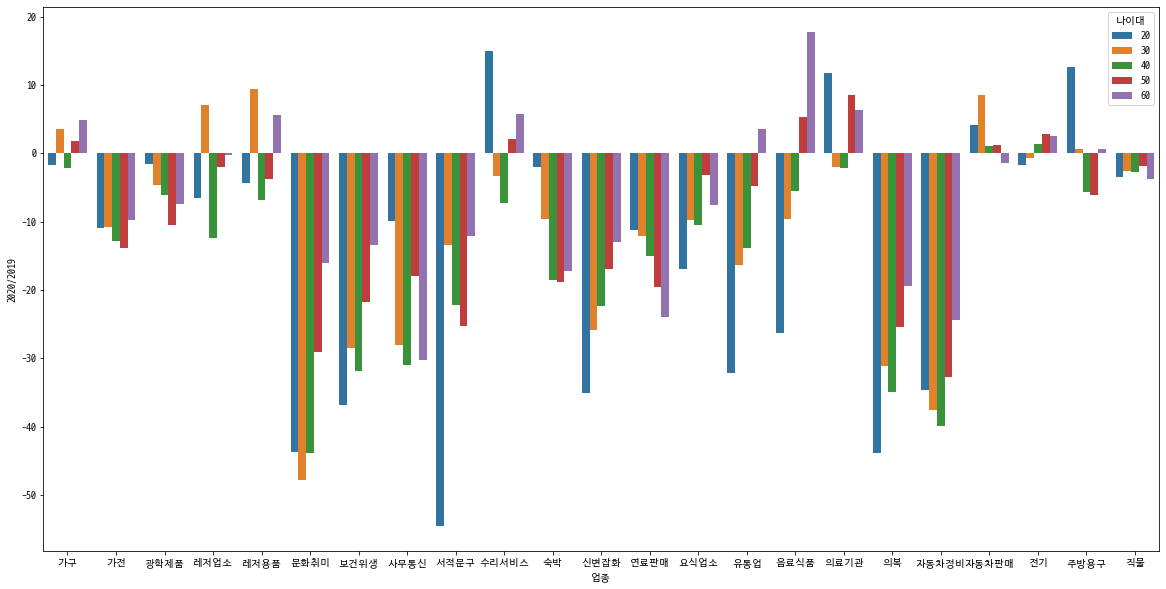

In [146]:
df_nai = df_origin
df_bigyo = df_nai[['Year','업종','이용건수','나이대']].groupby(['Year','업종','나이대']).mean()
df = df_bigyo.loc[2020]
df['2020/2019'] = (df_bigyo.loc[2020]['이용건수']-df_bigyo.loc[2019]['이용건수'])/df_bigyo.loc[2019]['이용건수']*100
sns.barplot(data = df.reset_index(), x = '업종', y = '2020/2019', hue='나이대')

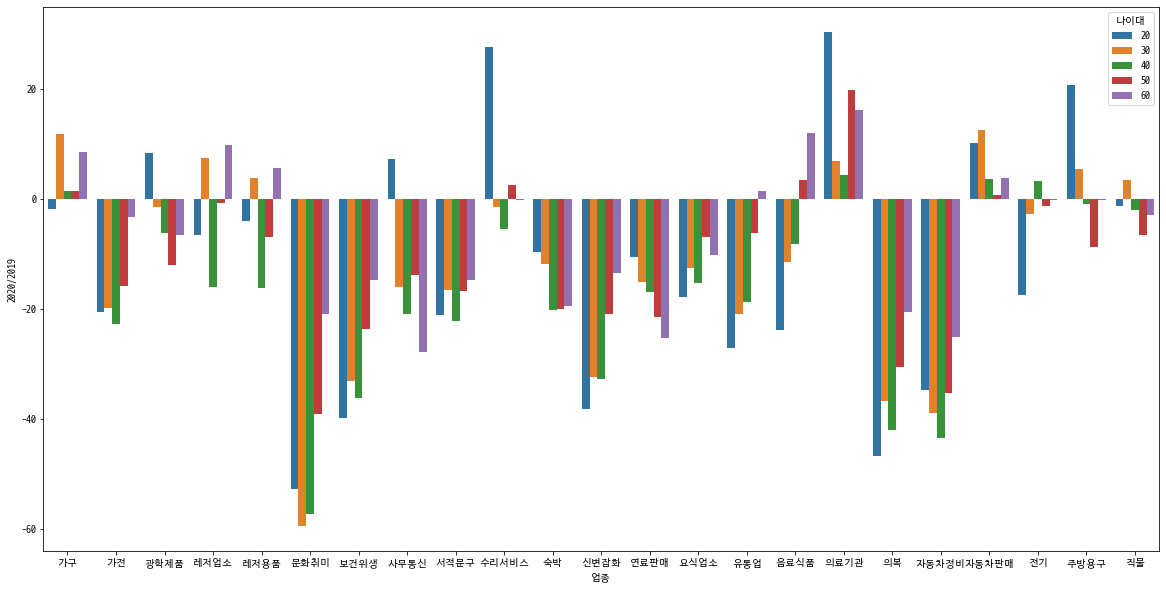

In [147]:
df_nai = df_nai.query('요일 == ["토","일"]')
df_bigyo = df_nai[['Year','업종','이용건수','나이대']].groupby(['Year','업종','나이대']).mean()
df = df_bigyo.loc[2020]
df['2020/2019'] = (df_bigyo.loc[2020]['이용건수']-df_bigyo.loc[2019]['이용건수'])/df_bigyo.loc[2019]['이용건수']*100
sns.barplot(data = df.reset_index(), x = '업종', y = '2020/2019', hue='나이대')

pd.read_pickle('modeling/data/주거인구.pkl')